<a href="https://colab.research.google.com/github/eileenrmartin/IntroToDASData/blob/master/BradyHotSprings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of horizontal DAS data acquired at Brady Hot Springs geothermal site with Vibroseis source



Notebook created by Eileen Martin at Virginia Tech, last edited July 31, 2020.

****TO DO: ADD BACKGROUND INFO AND PRETTY PICTURE  OF BRADY HOT SPRINGS

These data were acquired by the PoroTomo team: http://geoscience.wisc.edu/geoscience/people/faculty/feigl/porotomo/

Some of the analyses completed at this site with these seismic data (and other data as well) include:
*  X. Zeng, C. Thurber, H. Wang, D. Fratta, E. Matzel, PoroTomoTeam, 2017, "[High-resolution Shallow Structure  Revealed with Ambient Noise Tomography on a Dense Array](https://www.researchgate.net/profile/Dante_Fratta/publication/316092404_High-resolution_Shallow_Structure_Revealed_with_Ambient_Noise_Tomography_on_a_Dense_Array/links/58eff4a0a6fdcc11e569dc8d/High-resolution-Shallow-Structure-Revealed-with-Ambient-Noise-Tomography-on-a-Dense-Array.pdf)," Proceedings, 42nd Workshop on Geothermal Reservoir Engineering, Stanford University, Stanford, CA, Feb. 13-15. 
* K.L. Feigl and the PoroTomo Team, 2017, "[Overview and Preliminary Results from the PoroTomo project at Brady Hot Springs, Nevada: Poroelastic Tomography by Adjoint  Inverse Modeling of Data from Seismology, Geodesy, and Hydrology](https://www.researchgate.net/profile/Dante_Fratta/publication/316092238_Overview_and_Preliminary_Results_from_the_PoroTomo_project_at_Brady_Hot_Springs_Nevada_Poroelastic_Tomography_by_Adjoint_Inverse_Modeling_of_Data_from_Seismology_Geodesy_and_Hydrology/links/58eff6e1458515ff23a88b48/Overview-and-Preliminary-Results-from-the-PoroTomo-project-at-Brady-Hot-Springs-Nevada-Poroelastic-Tomography-by-Adjoint-Inverse-Modeling-of-Data-from-Seismology-Geodesy-and-Hydrology.pdf)," Proceedings, 42nd Workshop on Geothermal Reservoir Engineering, Stanford University, Stanford, CA, Feb. 13-15. 
* J. Patterson, M. Cardiff, T. Coleman, H. Wang, K. Feigl, J. Akerley, P. Spielman, 2017, "[Geothermal Reservoir Characterization Using Distributed Temperature Sensing at Brady Geothermal Field, Nevada](https://library.seg.org/doi/am-pdf/10.1190/tle36121024a1.1)," The Leading Edge, 36(12), 1024a1-1024a7.
* H.F. Wang, X. Zeng, D.E. Miller, D. Fratta, K.L. Feigl, C.H. Thurber, R.J. Mellors, 2018, "[Ground motion response to an ML 4.3 earthquake using co-located distributed acoustic sensing and seismometer arrays](https://academic.oup.com/gji/article/213/3/2020/4942237)," Geophysical Journal International, 213(3), 2020-2036.
* L.M. Parker, C.H. Thurber, X. Zeng, P. Li, N.E. Lord, D. Fratta, H.F. Wang, M.C. Robertson, A.M. Thomas, M.S. Karplus, A. Nayak, K.L. Feigl, 2018, "[Active-Source Seismic Tomography at the Brady Geothermal Field, Nevada with Dense Nodal and Fiber-Optic Seismic Arrays](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/545060/active-source-seismic-tomography-at-the-brady)," Seismological Research Letters, 89(5), 1629-1640.
* E.C. Reinisch, M. Cardiff, K.L. Feigl, 2018, "[Characterizing volumetric strain at Brady Hot Springs, Nevada, USA using geodetic data, numerical models and prior information](https://academic.oup.com/gji/article/215/2/1501/5078355)," Geophysical Journal International, 215(2), 1501-1513.
* Z. Li and Z. Zhan, 2018, "[Pushing the limit of earthquake detection with distributed acoustic sensing and template matching: a case study at the Brady geothermal field](https://academic.oup.com/gji/article/215/3/1583/5090146)," Geophysical Journal International, 215(3), 1583-1593. 
* ****TO DO: ADD theses/dissertation references : L. Parker, C. Lancelle, X. Zeng

The Python packages we'll use are:

*   numpy, already available in Colab: https://numpy.org/
*   matplotlib.pyplot, already available in Colab: https://matplotlib.org/
*   obspy, needs to be installed: https://docs.obspy.org/
*   scipy.fft, already available in Colab: https://docs.scipy.org/doc/scipy/reference/fft.html#module-scipy.fft
*   csv, already available in Colab: https://docs.python.org/3/library/csv.html
*   ipywidgets, already available in  Colab: https://ipywidgets.readthedocs.io/en/stable/

The only package we'll need to install is Obspy. To do this, we would normally type something like "pip install obspy" at the command line (if running this on our local laptops). Here we'll need to run a bash (command-line) command in our Jupyter notebook on Colab, so we'll use a ! before the command. Below is the command to install obspy. As done in the FORGE notebook, you can also use a -q flag here if you don't want to see the output from the Obspy installation.



In [1]:
!pip install obspy

     |████████████████████████████████| 24.7MB 168kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp36-cp36m-linux_x86_64.whl size=21667308 sha256=9b98fa230c8631022f342eceeaa67ec1ed2aab4728a31dcb5cddf4b3877735a9
  Stored in directory: /root/.cache/pip/wheels/94/e0/86/44fd4cea7661f42431c8f6d030f2758ff275cccffcbe8fa2b8
Successfully built obspy


All packages need to be imported before they can be used. Now that we've installed Obspy, let's load all relevant packages.

In [ ]:
import numpy as np
import scipy.fft as ft
import matplotlib.pyplot as plt
import obspy
import csv
import ipywidgets as widgets

# Reading Array Geometry

Grab the sensor array geometry information from the Geothermal Data Repository, which is stored in a csv file (comma separated value). File is at url: https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv 

and more info is at https://openei.org/doe-opendata/dataset/brady-s-geothermal-field-das-and-dts-surface-and-borehole-array-metadata/resource/f0000003-58cc-4372-a567-000000000829

Note that you could download this csv file to your laptop and ready it like an Excel file should you wish. 

In [ ]:
# Normally you would use the command below
# !wget https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv
# but we don't want to crash the GDR with 300+ people requesting the same file at once
# so here's a backup location and command on a public Google Drive folder:
!wget https://drive.google.com/file/d/1xl3diOA8eFHkPENqLEXgnynFpjcyORCn/view?usp=sharing

--2020-07-31 18:20:45--  https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv
Resolving gdr.openei.org (gdr.openei.org)... 52.27.59.5, 54.189.151.23, 54.186.144.32
Connecting to gdr.openei.org (gdr.openei.org)|52.27.59.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307372 (300K) [application/octet-stream]
Saving to: ‘Surface_DAS_DTS_UTM_coordinates.csv.1’

Surface_DAS_DTS_UTM 100%[===================>] 300.17K  1.19MB/s    in 0.2s    

2020-07-31 18:20:46 (1.19 MB/s) - ‘Surface_DAS_DTS_UTM_coordinates.csv.1’ saved [307372/307372]



Read the geometry data from the CSV file with geometry information. Note that some parameters (noted below) were noted on the website. 

In [ ]:
geomData = 'Surface_DAS_DTS_UTM_coordinates.csv'
# For this experiment,  some of the geometry is in this csv file. 
# if you look in the CSV file, these are the first and last rows with channels that have a location assigned
minRow = 53 
maxRow = 8673  
# read the geometry of all channels in the CSV file
with open(geomData) as myFile:
        myReader = csv.reader(myFile, delimiter=',')
        nRows = maxRow - minRow + 1
        ch = np.zeros(nRows,dtype=np.int) # array to hold channel indices
        x = np.zeros(nRows,dtype=np.float32) # array to hold x location
        y = np.zeros(nRows,dtype=np.float32) # array to hold y location
        myFile.seek(0)
        rowCtr = 1
        for row in myReader:
                if((rowCtr >= minRow) and (rowCtr <= maxRow)):
                        ch[rowCtr-minRow] = int(row[0])
                        x[rowCtr-minRow] = float(row[1])
                        y[rowCtr-minRow] = float(row[2])
                rowCtr = rowCtr + 1

In a later cell, we're going to use a data file with all sensors recording data while a single vibroseis seismic source is set off. The GDR website lists the location of this source. Let's calculate and plot the distance of each sensor from the source:



Text(0.5, 1.0, 'Distance of each sensor from example vibroseis source')

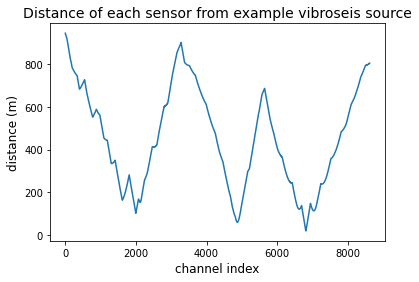

In [ ]:
# location of source from https://gdr.openei.org/submissions/849
# converted to UTM by https://www.latlong.net/lat-long-utm.html
srcX = 328552.49  # example source's x location in UTM meters 
srcY = 4408006.65 # example source's y location in UTM meters 

# calculate distances in meters of each sensor from the source location
distances = np.sqrt((x-srcX)**2 + (y-srcY)**2)
plt.plot(distances)
plt.xlabel("channel index",fontsize=12)
plt.ylabel("distance (m)",fontsize=12)
plt.title("Distance of each sensor from example vibroseis source",fontsize=14)

Plot the geometry of all channels. An easy way to do this is to do a scatter plot of all sensor locations, then color-code their markers by their corresponding channel index.

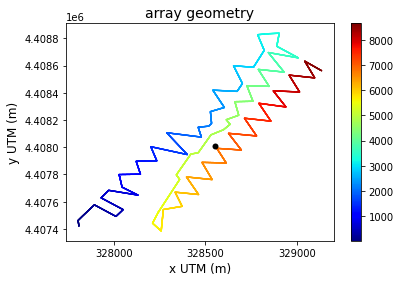

In [ ]:
plt.scatter(x,y,c=ch,linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)', fontsize=12)
plt.locator_params(axis='x', nbins=5) # reduce number of tick marks so labels aren't so crowded
plt.ylabel('y UTM (m)', fontsize=12)
plt.title('array geometry', fontsize=14)
plt.scatter(srcX,srcY,c='k',linewidth=0)

Grab the data acquired during a single vibroseis sweep from the Geothermal Data Repository (much larger file than geometry). Again, this will need to be done as a bash command with an !. This time we'll use the wget program to grab the data by its URL. 

More info at http://search.geothermaldata.org/dataset/98046653-40ef-4274-96e5-56bb8ae4dbde


In [ ]:
# Normally you would get data using the command below:
!wget https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy
# but we don't want to crash the GDR with a few hundred people requesting the 
# same file all at once, so instead use this command to access the data
# from a backup location in a public Google Drive folder:
# !wget *****UPDATE AFTER UPLOAD TO DRIVE DONE***

--2020-07-31 18:20:47--  https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy
Resolving gdr.openei.org (gdr.openei.org)... 52.27.59.5, 54.189.151.23, 54.186.144.32
Connecting to gdr.openei.org (gdr.openei.org)|52.27.59.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048616640 (1000M) [application/octet-stream]
Saving to: ‘PoroTomo_iDAS16043_160325140048.sgy.1’

PoroTomo_iDAS16043_ 100%[===================>]   1000M  33.7MB/s    in 31s     

2020-07-31 18:21:19 (32.2 MB/s) - ‘PoroTomo_iDAS16043_160325140048.sgy.1’ saved [1048616640/1048616640]



In [ ]:
chNumberFor0thTrace = -20 # had to look in the csv file to know this (specific to this dataset's channel/geometry mapping info)
startTrNumber = minRow # for full array # for just one segment you could instead use 5275 to 5490
endTrNumber =  maxRow # for full array 

# open up the SEGY file using Obspy
datafile = "PoroTomo_iDAS16043_160325140048.sgy"
# Read the file:
st = obspy.io.segy.core._read_segy(datafile, format='segy', unpack_trace_headers=True)
# Below is an alternative way to read:
# st = obspy.read(datafile,format='SEGY') # st is a stream and it has thousands of traces in it

# get header info from first channel (trace) of interest
stats = st[startTrNumber].stats
samplesPerSecond = stats.sampling_rate
secondsPerRecord = stats.npts*stats.delta
nSamples = stats.npts

# create an empty 2D numpy array to store data 
# (rows correspond to channel, columns correspond to time)
data = np.zeros((endTrNumber-startTrNumber+1,nSamples))

# read data from all channels and store in the numpy array
for tr in range(startTrNumber,endTrNumber+1):
	data[tr-startTrNumber,:] = st[tr].data

Let's visualize one of these channels (traces) with a wiggle plot:

(Thanks to Ethan Williams for pointing out that the semi-colon is needed on the end of this line due to the way ipython interacts with the Stream.plot() function)

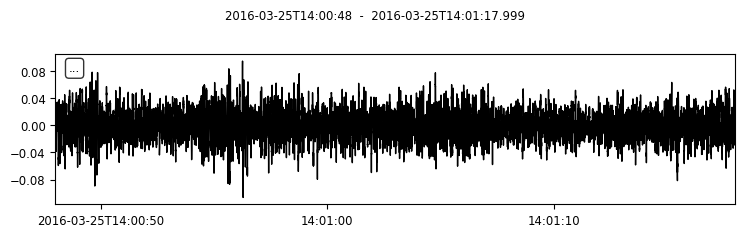

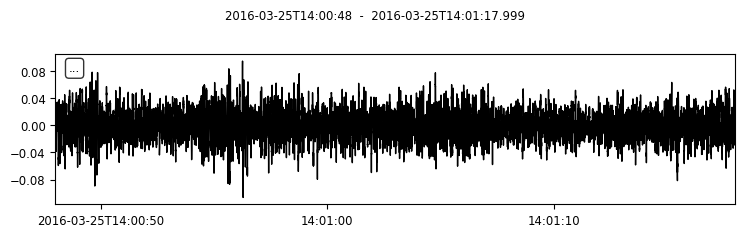

In [ ]:
st[startTrNumber].plot();

However, visualizing wiggles from a stream with thousands of traces would be difficult: crowded looking, and taking a long time to generate. Often in array  seismology, we use raster plots rather than wiggles to visualize many traces together. Define a function to plot an array of data from minCh to maxCh, and from minSec seconds to maxSec seconds with a title on the plot.

Here we'll use the seismic colormap (red - white - blue), with one pixel colored to indicate the strain rate at each time sample and channel. Other colormaps can be used for a variety of visualizations: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html


PURPOSE: 
This function plots a subset of someData from channel minCh to maxCh and minSec to maxSec seconds of time.

INPUTS: 
* someData: 2D numpy array, storing seismic data such that each row represents a channel, and columns represent time (i.e. 0th axis is channel, 1st axis is time)
* minSec: float, minimum time of interest (expressed in seconds beyond the start of someData)
* maxSec: float, maximum time of interest (expressed in seconds beyond the start of someData)
* minCh: int, minimum channel index of interest (don't forget offset of 0th channel if needed, as in BHS data)
* maxCh: int, maximum channel index of interest (don't forget offset of 0th channel if needed, as in BHS data)
* title: string, will be the title of your plot
* sampleRate: a float indicating number of samples per second (of each sensor)

In [ ]:
def plotSpaceTime(someData,minSec,maxSec,minCh,maxCh,title,sampleRate):

  # ****TO DO : add error checking***
  
  # turn time range (in seconds) to indices
  minSecID = int(minSec*sampleRate) 
  maxSecID = int(maxSec*sampleRate) 
  # make the plot
  plt.figure()
  plt.imshow(someData[minCh:maxCh,minSecID:maxSecID],aspect='auto',interpolation='none',cmap='seismic',extent=(minSec,maxSec,maxCh,minCh))
  plt.xlabel('time (s)',fontsize=12)
  plt.ylabel('channel',fontsize=12)
  plt.title(title,fontsize=14)
  plt.colorbar()

Now call this for the vibroseis sweep record.

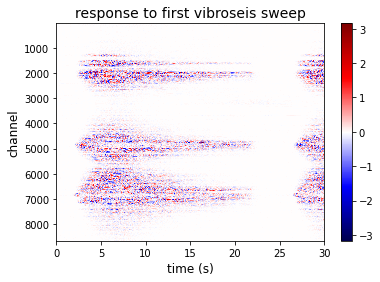

In [ ]:
title='response to first vibroseis sweep'
beginningCh = startTrNumber+chNumberFor0thTrace
endingCh =  endTrNumber+chNumberFor0thTrace
plotSpaceTime(data, 0, secondsPerRecord, beginningCh, endingCh, title, samplesPerSecond) # call the actual plotting function

Write a function to plot a snapshot of  the wavefield in time with a colored marker at each channel location. Each marker color should indicate the strain rate at the particular time and location.

INPUTS: 
* xLocs: 1D numpy array of floats, specifying x locations of channels in meters
* yLocs: 1D numpy array of floats, specifying y locations of channels in meters, should have same number of entries as xLocs
* dataChT: 2D numpy array of floats containing data organized so each row is a channel and columns indicate time
* timeInSeconds: float, indicating number of seconds beyond the start time of dataChT that you want to visualize the snapshot of data at
* sampleRate: float, number of samples per second acquired by each channel
* subsample: a positive integer, indicates the stride across channels if only a subset of channels will be visualized. For instance subsample=2 would take every other channel/row starting with the 0th index in dataChT. If = 1 (which is the default) no spatial subsampling is done.
* clip: float, a nonegative number that sets the maximum value in the colorbar. By default this is 0 which would then be a flag to set the max positive value in the colorscale to the maximum absolute value throughout dataChT.

No outputs, just generates a figure.

In [ ]:
def plotTimeSnapshot(xLocs, yLocs, dataChT, timeInSeconds, sampleRate, subsample=1, clip=0):
  # TO DO: add a little error checking on the inputs *******

  # time sample of interest
  timeID = int(timeInSeconds*sampleRate)

  # default color clipping behavior is to just set the max color value to the max absolute value in this snapshot
  if(clip == 0):
    clip = np.max(np.absolute(dataChT[:,timeID])) 

  plt.figure()
  plt.scatter(xLocs[::subsample],yLocs[::subsample],c=dataChT[::subsample,timeID],linewidth=0,s=2,cmap='seismic',vmin=-clip,vmax=clip)
  plt.colorbar()
  plt.xlabel('x UTM (m)')
  plt.locator_params(axis='x', nbins=5) # reduce number of tick marks so labels aren't so crowded
  plt.ylabel('y UTM (m)')
  plt.title('signal at '+str(timeInSeconds)+' seconds',fontsize=14)

Plot a snapshot of the wavefield at a particular time, 3.5 seconds for example.

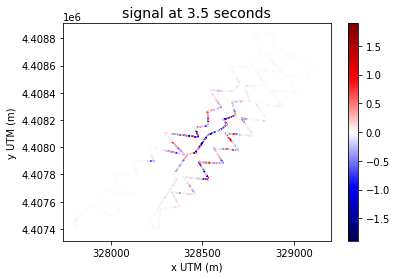

In [ ]:
time = 3.5 # time of intereset (in seconds)
plotTimeSnapshot(x, y, data, time, samplesPerSecond)

We can use a widget to easily change the time of the snapshot. As you move the widget to different times, look back at the raster plot above showing all channels. Does this make sense with what you're seeing there?

Note: it does take a little time to regenerate each one, so if you're impatient you may want to set subsample to an integer > 1 (so for instance is subsample = 10, then only every 10th channel will be plotted).

In [ ]:
# set a single  color clip for all time snapshots (so they're all on the same colorscale)
overallClip  = np.percentile(np.absolute(data),99) # take the 99th %tile of absolute values of whole data window as max

def interactiveSnapshot(timeInSec):
  # This is a wrapper around plotTimeSnapshot so that the widget just depends on the 
  # time of interest in seconds. This has no subsampling (so 2nd to last arg is 1).
  plotTimeSnapshot(x, y, data, timeInSec, samplesPerSecond, 1, overallClip)

# has a widget that lets you check the time snapshot at 1, 1.5, 2, 2.5, ..., 24.5, 25 seconds
interactive_plot = widgets.interactive(interactiveSnapshot, timeInSec=(1,25,0.5)) 
interactive_plot

interactive(children=(FloatSlider(value=13.0, description='timeInSec', max=25.0, min=1.0, step=0.5), Output())…

## Effect of sensor orientation on  response

Let's zoom in on just channels 1500-2500 during 7-8 seconds while the vibroseis sweep is happening. These channels make a few tight turns, so they'll let us see how response varies with geometry. First check  out this subset of the geometry.

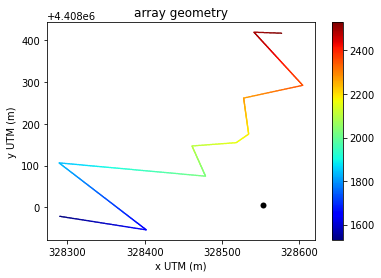

In [ ]:
startCh = 1500
endCh = 2500
startSec = 7
endSec = 8

plt.scatter(x[startCh:endCh],y[startCh:endCh],c=ch[startCh:endCh],linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)') 
plt.locator_params(axis='x', nbins=5)
plt.ylabel('y UTM (m)')
plt.title('array geometry')
plt.scatter(srcX,srcY,c='k',linewidth=0) # plot the source location
plt.show()

Now actually plot the data. Investigate where the corners of the array line up with the data, and the direction of the waves moving outwards from the source. What do you notice?



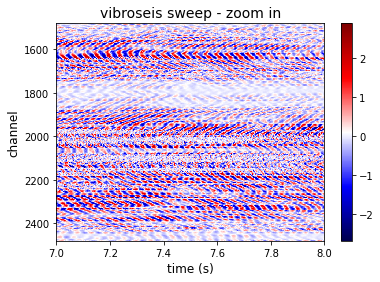

In [ ]:
title='vibroseis sweep - zoom in'
beginningCh = startCh+chNumberFor0thTrace # because of the channel indexing offset, don't forget this
endingCh =  endCh+chNumberFor0thTrace
plotSpaceTime(data, startSec, endSec, beginningCh, endingCh, title, samplesPerSecond) # call the actual plotting function

**Array geometry questions for small group investigation:**

1. Look at the last segment. How would waves from that source location be hitting it? What do you notics about the amplitudes?
2. Why is the amplitude from ~1750 to ~1900 so much lower than 1500 to ~1650 even though it is closer to the source? 
3. Change your visualization codes in the cell above and below so you can zoom in on much smaller subsets of channels. Can you figure out where corners are based on the waveforms?
4. Try zooming in on different subsets of the array. What do you see about their response? 

## Spectral Analysis

Often we can understand some of our sensor response by looking at space-time domain data, but we can learn more by also looking at the spectrum of our data in the frequency domain. 

If you aren't familiar with the Fourier Transform, this video by Brian Douglas is a good starting place: https://www.youtube.com/watch?v=1JnayXHhjlg

Here, we'll use the Scipy Fourier Transform package: https://docs.scipy.org/doc/scipy/reference/fft.html#module-scipy.fft
which has multiple implementations based on the Fast Fourier Transform (FFT) algorithm. 

For visualizing how much wave energy is being  detected at each frequency, we often look at the amplitude spectrum (magnitude of the complex-valued Fourier transform at each frequency), and sometimes at the power spectrum (squared magnitude of the complex-valued Fourier transform  at each frequency). 

In the cell below, we define a function to calculate the power spectrum of a single channel's recording.

In [ ]:
def plotSpecOneCh(chOfInterest,dataArray,sampleRate,title): 
  # ****TO DO: add error checking on inputs***

  spectrum = ft.fft(dataArray[chOfInterest,:])
  frqBins = int(spectrum.size/2)
  # frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  frqs = np.linspace(0,NyquistFrq,num=frqBins)

  plt.figure()
  plt.plot(frqs,np.absolute(spectrum[:frqBins]))
  plt.xlabel('Frequency (Hz)',fontsize=12)
  plt.ylabel('Amplitude',fontsize=12)
  plt.title(title)


Let's plot this for one particular  channel of interest, 2300 (remember to offset by the index in data of the  0th  channel).

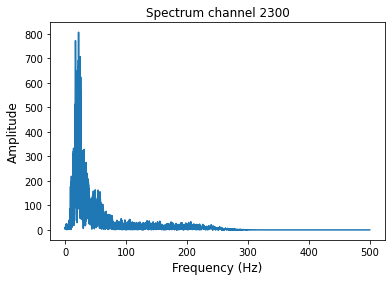

In [ ]:
ch = 2300
plotSpecOneCh(ch+chNumberFor0thTrace,data,samplesPerSecond,'Spectrum channel '+str(ch))

Define a function that will plot the amplitude spectrum of each channel (amplitude indicated by color) within a certain time window and frequency range.


INPUTS:
* dataArray: 2D numpy array of space-time domain seismic data, rows represent channels, columns represent time samples
* minSec: float, minimum time (seconds) from the start of the dataArray of interest
* maxSec:  float, maximum time (seconds) from the start of the dataArray of interest
* minCh: int, minimum channel index of interest (don't forget offset of 0th channel if needed, as in BHS data)
* maxCh: int, maximum channel index of interest (don't forget offset of 0th channel if needed, as in BHS data)
* minFrq: float, minimum frequency of interest (Hz)
* maxFrq:  float, maximum frequency of interest (Hz)
* sampleRate: float, number of samples per second acquired by each sensor
* title: string, what you'd like as your plot title
* scale: string, keyword of either 'linear' or 'log10' specifying whether the plot is colored based on the amplitudes or the log_10 of the amplitudes.

In [ ]:
def plotArraySpec(dataArray, minSec, maxSec, minCh, maxCh, minFrq, maxFrq, sampleRate, title,  scale='linear'):

  # check for valid inputs (note- these checks aren't exhaustive)
  if(maxFrq <= minFrq):
    print("ERROR in plotArraySpec inputs: minFrq "+str(minFrq)+" >= maxFrq "+str(maxFrq))
    return
  if maxSec <= minSec:
    print("ERROR in plotArraySpec inputs: minSec "+str(minSec)+" >= maxSec "+str(maxSec))
    return
  if (scale != 'linear')  and (scale  != 'log10'): # only 2 scale keywords are recognized
    print("ERROR  in plotArraySpec inputs: scale keyword "+scale+" is not recognized")

  # figure out sample indices for time window of interest
  startTimeIdx =  int(minSec*sampleRate)
  endTimeIdx = int(maxSec*sampleRate)
  if endTimeIdx > dataArray.shape[1]: # another opportunity for error checking: don't request a time bigger than what's available.
    print("ERROR in plotArraySpec inputs: maxSec "+str(maxSec)+" exceeds last time in dataArray")

  # calculate the amplitude spectrum (not amplitude symmetry for +/- frequencies)
  spectrum = ft.fft(dataArray[minCh:maxCh+1,startTimeIdx:endTimeIdx+1],axis=-1) 
  nFrqBins = int(spectrum.shape[1]/2) # number of frequency bins 
  amplitudeSpec =np.absolute(spectrum[:,:nFrqBins])

  # calculate indices corresponding to the frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  # make sure maxFrq doesn't exceed Nyquist  frequency
  if(maxFrq > NyquistFrq):
    print("ERROR in plotArraySpec inputs: maxFrq "+str(maxFrq)+" >= Nyquist frequency "+str(NyquistFrq)+" indicated by sampleRate "+str(sampleRate))
    return
  # convert frequencies to an index in the array
  HzPerBin = NyquistFrq/float(nFrqBins) 
  minFrqIdx =  int(minFrq/HzPerBin) 
  maxFrqIdx =  int(maxFrq/HzPerBin)
  frqs = np.linspace(minFrqIdx*HzPerBin,maxFrqIdx*HzPerBin,num=(maxFrqIdx-minFrqIdx+1))

  # actually do the plot
  plt.figure()
  if scale  == 'linear':
    plt.imshow(amplitudeSpec[minCh:maxCh,minFrqIdx:maxFrqIdx],aspect='auto',interpolation='none',cmap='inferno',extent=(minFrq,maxFrq,maxCh,minCh)) 
  elif scale == 'log10':
    plt.imshow(np.log10(amplitudeSpec[minCh:maxCh,minFrqIdx:maxFrqIdx]),aspect='auto',interpolation='none',cmap='inferno',extent=(minFrq,maxFrq,maxCh,minCh)) 
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Channel')
  plt.colorbar()
  plt.title(title)


Let's first look at all channels' amplitude spectra up to a few hundred Hz for the entire sweep (say 0 to 25 seconds):

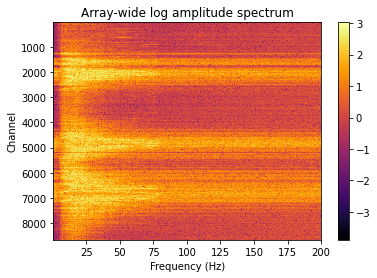

In [ ]:
# visualize same channels as you did for whole time domain plot above
beginningCh = startTrNumber+chNumberFor0thTrace
endingCh =  endTrNumber+chNumberFor0thTrace
# choose frequency range of interest
minFrq = 0.5
maxFrq = 200
# choose which time window to investigate
startSec =  0
endSec = 25
# call the function to plot
plotArraySpec(data, startSec, endSec, beginningCh, endingCh, minFrq, maxFrq, samplesPerSecond, 'Array-wide log amplitude spectrum','log10')

***Spectral analysis questions for small group investigation:***

Add some cells to look at different subsets of the frequency content, subsets in time, and in space. Investigate some of the following questions:
1. During this vibroseis sweep how does the frequency content change over time?
2. How does the frequency content differ on channels that are closer to the  source? Farther from the source? 
3. Does the geometry matter in the frequency content acquired on a channel? 
4. How much does using the linear or log plot matter in finding spectral variability in space/time? Does the colormap matter in your ability to visualize these changes? Investigate this by changing the cmap parameter, and changing log or linear (maybe even add it as a parameter in the function call).
5. Within a single channel, we often use a "waterfall plot" that shows the spectral amplitude after calculating the short time Fourier transform in many shorter successive time windows. Try to code this up and use it to investigate changes over time on different channels. 